In [47]:
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# import h5py
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.python.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import Model
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from sklearn.metrics import f1_score, accuracy_score

In [48]:
data_dir  = '../input/chest-xray-pneumonia/chest_xray/chest_xray/'
train_dir = data_dir+'train/'
test_dir  = data_dir+'test/'
val_dir   = data_dir + 'val/'

In [49]:
normal_cases = glob(train_dir+'NORMAL/*.jpeg')
pneumonia_cases = glob(train_dir+'PNEUMONIA/*.jpeg')

In [50]:
print(len(normal_cases),len(pneumonia_cases))
print(len(normal_cases)/(len(normal_cases)+len(pneumonia_cases)),len(pneumonia_cases)/(len(normal_cases)+len(pneumonia_cases)))

1341 3875
0.2570935582822086 0.7429064417177914


In [51]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []
trainset=[]

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))
   # n= cv2.imread(img)
    #trainset.append(n)

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

In [52]:
#trainset = pd.DataFrame(trainset,index=None)

In [53]:
train_data.head()

,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,1
1,../input/chest-xray-pneumonia/chest_xray/chest...,1
2,../input/chest-xray-pneumonia/chest_xray/chest...,0
3,../input/chest-xray-pneumonia/chest_xray/chest...,1
4,../input/chest-xray-pneumonia/chest_xray/chest...,0


1    3875
0    1341
Name: label, dtype: int64


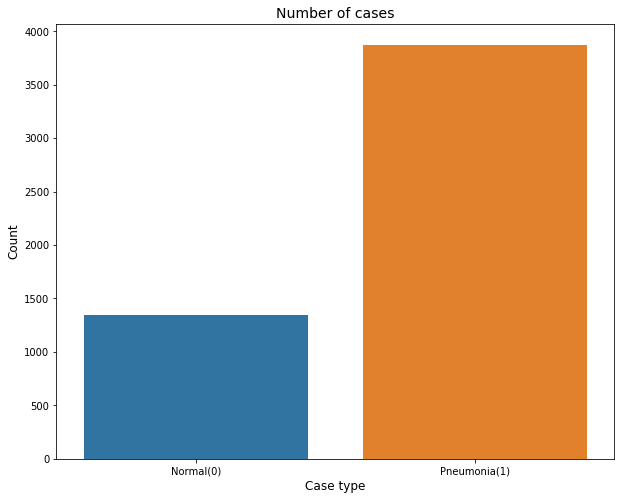

In [54]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

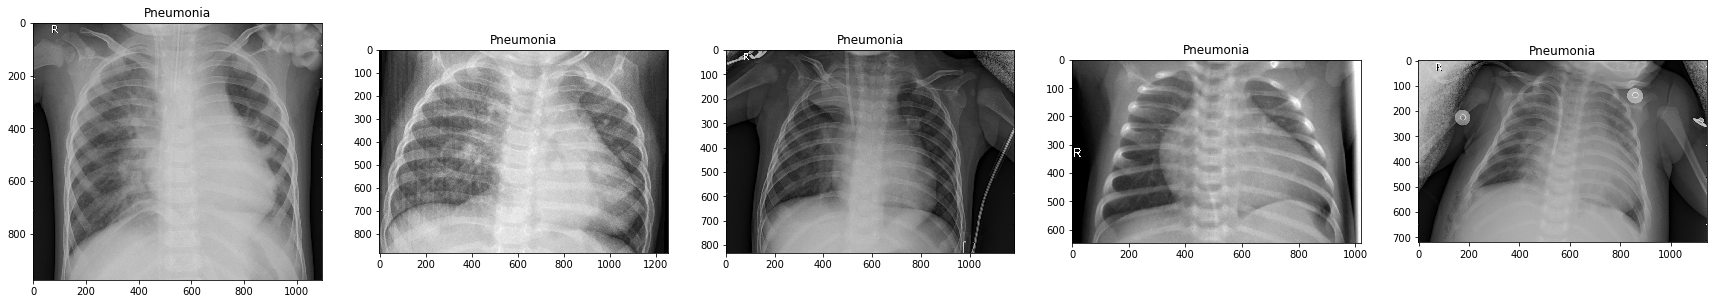

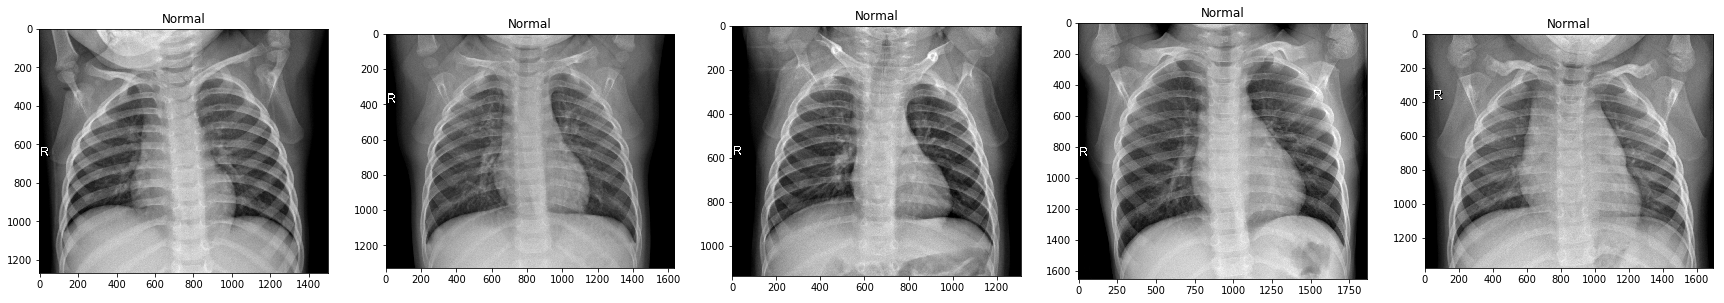

In [55]:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()


# Plot the data  
f, ax = plt.subplots(1,5, figsize=(30,30))

for i in range(5):
    img = imread(pneumonia_samples[i])
    ax[i%5].imshow(img, cmap='gray')
    ax[i%5].set_title("Pneumonia")
plt.show()

f, ax = plt.subplots(1,5, figsize=(30,30))

for i in range(5):
    img = imread(normal_samples[i])
    ax[i%5].imshow(img,cmap='gray')
    ax[i%5].set_title("Normal")
plt.show()

In [56]:
image_size = 150
nb_train_samples = 5216 # number of files in training set
batch_size = 16

EPOCHS = 6
STEPS = nb_train_samples / batch_size

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2
                                            )
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator_with_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val/',
       target_size = (image_size, image_size),
       class_mode = 'categorical')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [67]:
train_generator.image_shape

(150, 150, 3)

In [58]:
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions

In [59]:
num_classes = 2
EPOCHS = 10
STEPS = nb_train_samples / batch_size

In [71]:
vgg_weights_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16 = VGG16(pooling='avg', 
                  weights=vgg_weights_path,
                  input_shape=(image_size, image_size, 3),
                  include_top = False)

# Freeze all layers in Resnet
for layer in vgg16.layers:
    layer.trainable = False

# Stack the pre-trained model with a fully-connected layer
# Add fully-connect layer (aka Dense layer) with softmax activation
x = vgg16.output
# x = Flatten()(x)
# x = Dense(num_classes, activation='softmax')(x)

# FC layer
x = Flatten()(x)
x = Dense(units=4096, activation='relu')(x)
# x = Dropout(rate=0.3)(x)
# x = Dense(units=4096, activation='relu')(x)
# x = Dropout(rate=0.3)(x)
x = Dense(units=2, activation='softmax')(x)



# Define loss function, optimizer and metrics
model = Model(inputs=vgg16.input, outputs= x)

optimizer = Adam(lr = 0.0001)
early_stopping_monitor = EarlyStopping(patience = 3, monitor = "val_acc", mode="max", verbose = 2)
model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [73]:
model.fit_generator(
    train_generator, # specify where model gets training data
    epochs = EPOCHS,
    steps_per_epoch=STEPS,
    validation_data=validation_generator, # specify where model gets validation data
    callbacks=[early_stopping_monitor])

# history = model.fit_generator(epochs=5, callbacks=[early_stopping_monitor], shuffle=True, validation_data=val_batches, generator=train_batches, steps_per_epoch=500, validation_steps=10,verbose=2)

# Evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10
326/326 [==============================] - 98s 300ms/step - loss: 0.2928 - acc: 0.9095 - val_loss: 0.0777 - val_acc: 0.9375
Epoch 2/10
326/326 [==============================] - 89s 273ms/step - loss: 0.1760 - acc: 0.9411 - val_loss: 0.6311 - val_acc: 0.7500
Epoch 3/10
326/326 [==============================] - 90s 276ms/step - loss: 0.1984 - acc: 0.9352 - val_loss: 1.5131 - val_acc: 0.6875
Epoch 4/10
326/326 [==============================] - 89s 274ms/step - loss: 0.1863 - acc: 0.9433 - val_loss: 0.1225 - val_acc: 0.9375
Epoch 00004: early stopping

acc: 90.06%


In [66]:
# # Load the pre-trained model
# vgg_weights_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#
 #model = Sequential()
 #model.add(VGG16(include_top=False, pooling='avg', weights=vgg_weights_path))
 #model.add(Dense(units=2, activation='softmax'))
 #model.layers[0].trainable = False

 #model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
#model.summary()

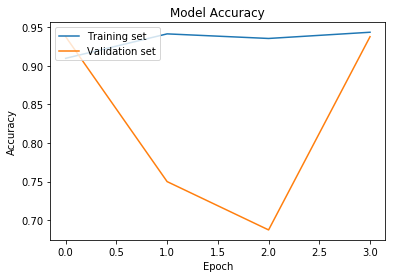

In [74]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

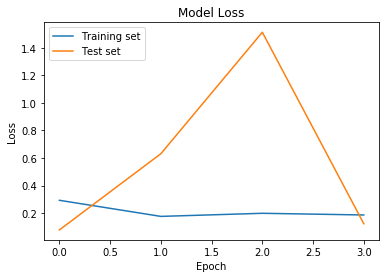

In [75]:
# Loss 
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()